In [1]:
'''
This script was developed by Alex, Jiurai, Boris and Paula.
OHW 2023

Date: 10-08-2023

The objective of this script is to use SST satellite data to train a deep learning ConvLSTM model able to predict SST for the following day.
The idea of this script is to provide a model that could be run in a low memory machine, as a first approach to be followed and developed. 
'''

import MUR_data_and_machine_learning_model_adapted as mu
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import gc
import random
import os

#Load the SST data
ds = mu.load_the_dataset()

#Time slice to use for training:
time_slice = slice("2002-06-01", "2002-06-30")

#Overall lat/lon area for the study
lat_all = [-4, 32]
lon_all = [44, 90]

#A lot of the data is land, which we don't want for training, so set limits on what's allowed:
lat_lon = [[-5, 15, 50, 75],
           [-5, 15, 80, 90],
           [15, 25, 60, 70]]


#Set the model hyper parameters
batch_size = 64 #Data batch to load in
step_size = 2 #size of the square, degrees lat by degrees lon

num_tiles = 10 #This is the number of times it selects different input lat/lon tiles
num_epochs = 1 # This is the number of training epochs per tile, so don't want this to be too large

lats = np.arange(lat_all[0], lat_all[1], step_size)  
lons = np.arange(lon_all[0], lon_all[1], step_size)

#Set the outputs
parent_folder = os.getcwd()
model_path = parent_folder + '/sst_model'


ModuleNotFoundError: No module named 'MUR_data_and_machine_learning_model_adapted'

In [28]:
# Rather than stepping through the lat and lon in 2 loops, randomly select the lat and lon tiles
run_number = 0 # initialize this so the model knows to initialize
for num in np.arange(0,num_tiles):
    
    good_combo = 0
    while good_combo == 0:
        #Randomly select lat/lon tiles
        lat = random.randint(lat_all[0],lat_all[1]-step_size)
        lon = random.randint(lon_all[0],lon_all[1]-step_size)
        lat = [lat, lat+step_size]
        lon = [lon, lon+step_size]
        #print('lat {}'.format(lat))
        #print('lon {}'.format(lon))
        for ii in np.arange(0,3):
            #print(lat_lon[ii])
            if lat[0]>=lat_lon[ii][0] and lat[1]<=lat_lon[ii][1] and lon[0]>=lat_lon[ii][2] and lon[1]<=lat_lon[ii][3]:
                good_combo = 1
    
    #Load the tile:
    #print(f'{lat}, {lon}')
    X_train, y_train, X_val, y_val, X_test, y_test = mu.pull_a_tile(ds,lat,lon,time_slice)[1:]

    if run_number == 0:
        #Compile the model:
        #model = mu.create_transformer_model(np.shape(X_train)[1:] + (1,))
        model = mu.create_simple_model(np.shape(X_train)[1:] + (1,))
        #model = create_simple_model()
        model.summary()
        model.compile(optimizer='adam', loss='mse', metrics=['mse'])
        early_stop = EarlyStopping(patience=5, restore_best_weights=True)

    #Train the model:
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val_dataset = val_dataset.batch(32)

    history = model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset, callbacks=[early_stop])

    #Increment the run number
    run_number += 1

    #Delete the data to free up memory:
    del X_train, y_train, X_val, y_val, X_test, y_test
    gc.collect()
    
#Save the model
model.save(model_path)

[11, 13], [87, 89]
lat [11, 13]
lon [87, 89]
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_2 (ConvLSTM2D)  (None, 201, 201, 32)      38144     
                                                                 
 batch_normalization_2 (Bat  (None, 201, 201, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_2 (Conv2D)           (None, 201, 201, 1)       289       
                                                                 
Total params: 38561 (150.63 KB)
Trainable params: 38497 (150.38 KB)
Non-trainable params: 64 (256.00 Byte)
_________________________________________________________________
1/1 [==============================] - 17s 17s/step - loss: 0.1456 - mse: 0.1456 - val_loss: 0.1195 - val_mse: 0.1195
[1, 3], [57, 59]
lat [1, 3]
lon [57, 59]
1/1 [==

INFO:tensorflow:Assets written to: /home/jovyan/ohw23_proj_sst/individual_folders/alex/sst_model/assets


lat [8, 10]
lat [8, 10]
lon [80, 82]
(5, 201, 201)
(201, 201)
1/1 [==============================] - 1s 521ms/step
(201, 201, 1)
MAE between Predicted Output and True Output: 0.3016083538532257
MAE between Last Input Frame and True Output: 0.08549519628286362


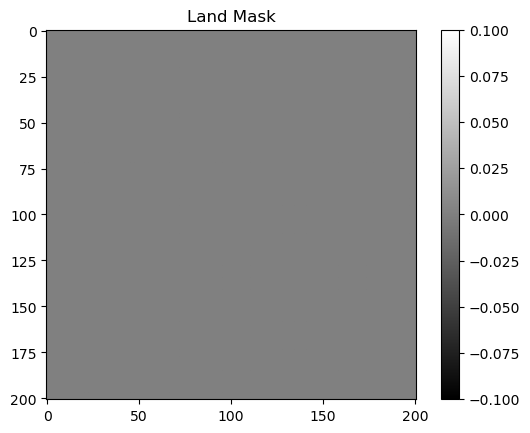

In [8]:
#Load the model that was trained:
model = tf.keras.models.load_model(model_path)

#Set the lat/lon to use:
lat = [5,7]
lon = [50,52]   

#Randomly select the lat/lon:
good_combo = 0
while good_combo == 0:
    #Randomly select lat/lon tiles
    lat = random.randint(lat_all[0],lat_all[1]-step_size)
    lon = random.randint(lon_all[0],lon_all[1]-step_size)
    lat = [lat, lat+step_size]
    lon = [lon, lon+step_size]
    #print('lat {}'.format(lat))
    #print('lon {}'.format(lon))
    for ii in np.arange(0,3):
        #print(lat_lon[ii])
        if lat[0]>=lat_lon[ii][0] and lat[1]<=lat_lon[ii][1] and lon[0]>=lat_lon[ii][2] and lon[1]<=lat_lon[ii][3]:
            good_combo = 1

dscut, X_train, y_train, X_val, y_val, X_test, y_test = mu.pull_a_tile(ds,lat,lon,time_slice)
mu.explore_results(X_test, model, dscut)

#To do the full implementation: iterate through different lat/lon squares
do_all = 0
if do_all:
    for lat in lats:
        lat = [lat, lat+step_size]

        for lon in lons:
            lon = [lon, lon+step_size]

            #Predict every tile
            dscut, X_train, y_train, X_val, y_val, X_test, y_test = mu.pull_a_tile(ds,lat,lon,time_slice)
            mu.explore_results(X_test, model, dscut)
